<h3> Introduce custom volatilities(standard deviations) in correlated time series <h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series
        
        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)
            
            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise
            
            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)
            
            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion
            
            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None
    
    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]
    
    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])
            
            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()
            
            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)
            
            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants
    
    return best_params, best_error

In [110]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [111]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.2]
Best error: 0.10710831455030978


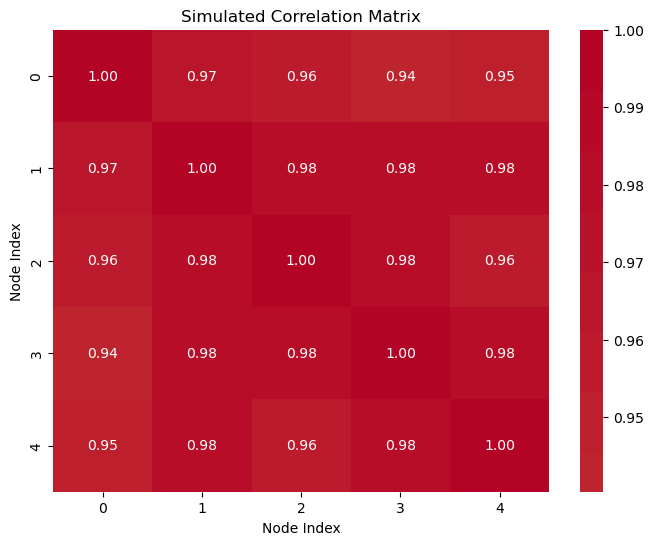

In [112]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

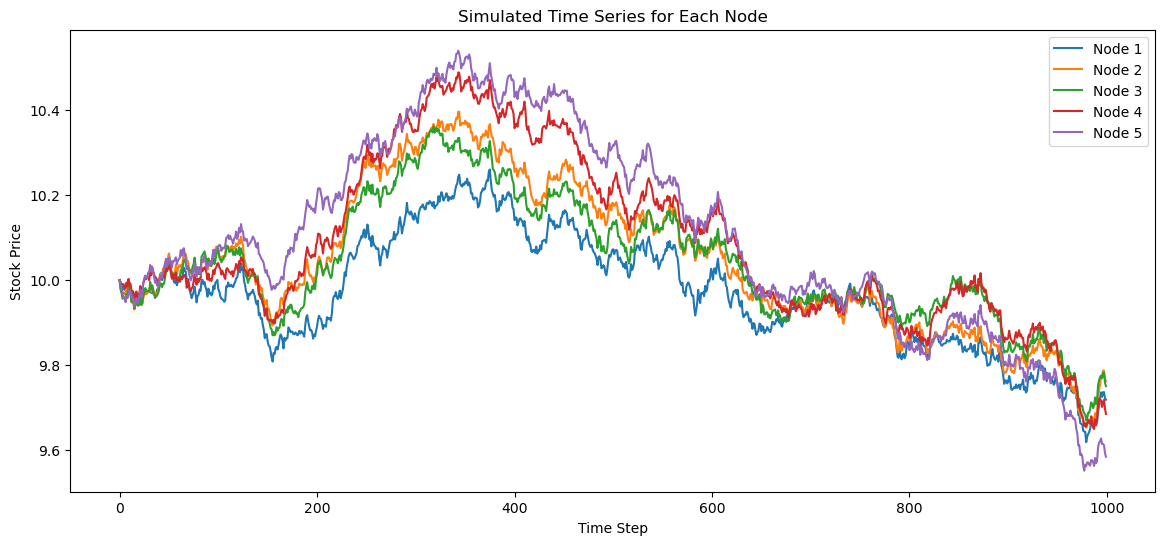

In [113]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [114]:
def adjust_volatility(time_series, desired_volatility):
    # Step 1: Stationarize the time series by taking the first difference (or returns)
    x_diff = np.diff(time_series)
    
    # Step 2: Normalize the differenced series
    mean_diff = np.mean(x_diff)
    std_diff = np.std(x_diff)
    x_norm = (x_diff - mean_diff) / std_diff
    
    # Step 3: Rescale to desired volatility (standard deviation) and mean
    x_rescaled = x_norm * desired_volatility 
    
    # Step 4: Convert back to original values by cumulative sum
    adjusted_series = np.cumsum(x_rescaled) + time_series[0]  # Add the first original value back
    
    return adjusted_series

In [115]:

class TimeSeriesHandler:
    def __init__(self, t_series):
        """
        Initializes the TimeSeriesHandler with multiple time series.

        Parameters:
        - t_series: 2D NumPy array of time series (shape: num_series x num_points)
        """
        self.t_series = t_series

    def adjust_volatility(self, time_series, desired_volatility):
        """
        Adjusts the volatility of a single time series.

        Parameters:
        - time_series: 1D array of the time series to adjust.
        - desired_volatility: The target volatility for the adjusted series.

        Returns:
        - adjusted_series: The adjusted time series.
        """
        # Step 1: Stationarize the time series by taking the first difference (or returns)
        x_diff = np.diff(time_series)

        # Step 2: Normalize the differenced series
        mean_diff = np.mean(x_diff)
        std_diff = np.std(x_diff)
        x_norm = (x_diff - mean_diff) / std_diff

        # Step 3: Rescale to desired volatility (standard deviation) and mean
        x_rescaled = x_norm * desired_volatility

        # Step 4: Convert back to original values by cumulative sum
        adjusted_series = np.cumsum(x_rescaled) + time_series[0]  # Add the first original value back
        
        return adjusted_series

    def adjust_all_volatilities(self, volatilities):
        """
        Adjusts the volatility for all time series stored in the class using provided volatilities.

        Parameters:
        - volatilities: 1D array of target volatilities for each time series.

        Returns:
        - adjusted_series_list: List of adjusted time series.
        """
        adjusted_series_list = []
        
        for i in range(self.t_series.shape[0]):  # Loop through each time series
            scaling_fac = 0.5/np.std(adjust_volatility(t_series.time_series[i],0.5))
            adjusted_series = self.adjust_volatility(self.t_series[i, :], scaling_fac*volatilities[i])
            adjusted_series_list.append(adjusted_series)
        
        return adjusted_series_list

In [116]:
handler = TimeSeriesHandler(t_series.time_series)

In [117]:
# Create desired volatilities for each time series
desired_volatilities = np.array([1.2, 1.0, 1.5, 2.0, 2.5])

# Initialize the TimeSeriesHandler with the sample data
handler = TimeSeriesHandler(t_series.time_series)

# Adjust the volatility of all time series
adjusted_series_list = handler.adjust_all_volatilities(desired_volatilities)

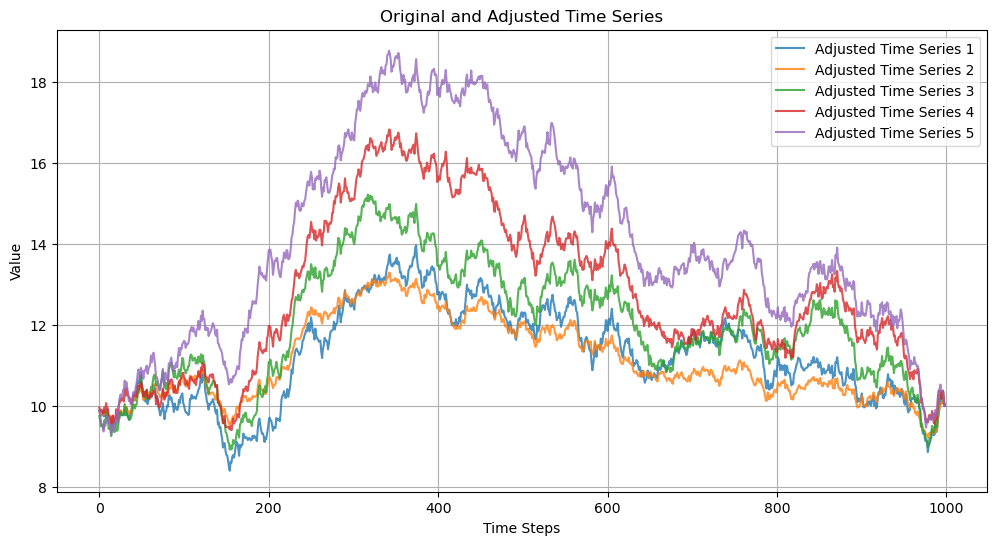

In [118]:
# Plotting the original and adjusted time series
plt.figure(figsize=(12, 6))
    
# Plot adjusted time series
for i, adjusted_series in enumerate(adjusted_series_list):
    plt.plot(adjusted_series, label=f"Adjusted Time Series {i+1}", alpha=0.8)

plt.title("Original and Adjusted Time Series")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

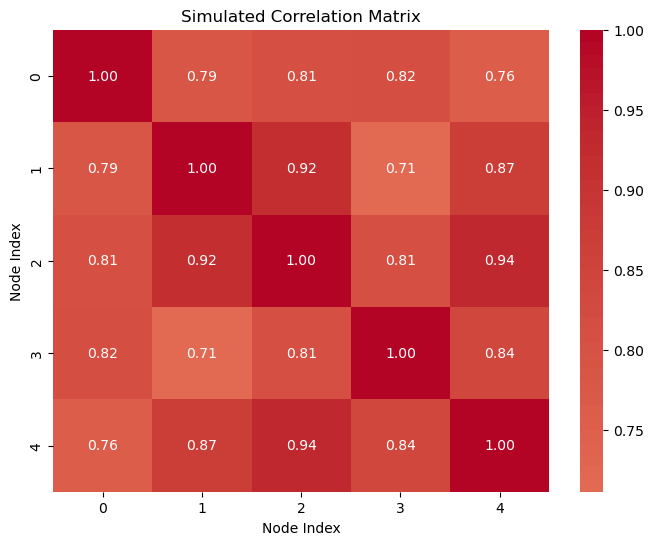

In [119]:
# Plotting the correlation matrix
simulated_correlation_matrix = np.corrcoef(adjusted_series_array)
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [120]:
#Final volatilties

for i in adjusted_series_list:
    print(np.std(i))

1.2000000000000004
0.9999999999999999
1.5000000000000004
2.000000000000001
2.4999999999999973
